In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

from model import ParkinsonsLSTM, train, eval
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

tqdm.pandas()

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

load parsed data

In [2]:
df = pd.read_csv('keystroke_data.csv', low_memory=False)

In [3]:
df.groupby(['parkinsons', 'tremors']).userkey.nunique()

parkinsons  tremors
False       False      52
            True        3
True        False      65
            True       97
Name: userkey, dtype: int64

define splits of 100 keystrokes and exclude users with less than target

In [4]:
target_length = 100
df['split'] = df.groupby('userkey').cumcount() // target_length

df = df.groupby('userkey').filter(lambda group: len(group) >= target_length).reset_index(drop=True)

add features. 1 lag to indicate the next keytap info and rolling mean and std with 3 window.

missing values are imputed with forward and backward fill

In [5]:
def add_features(df, lag_value=1, rolling_window=3):
    main_columns = ['hold_time', 'latency_time', 'flight_time']
    group_columns = ['userkey', 'split']
    for col in main_columns:
        for i in range(1, lag_value + 1):
            col_name = f'{col}_lag_{i}'
            df[col_name] = df.groupby(group_columns)[col].shift(-i)
            df[col_name] = df[col_name].fillna(method='ffill')
        df[f'{col}_rolling_mean'] = df.groupby(group_columns)[col].rolling(window=rolling_window).mean().reset_index( drop=True)
        df[f'{col}_rolling_std'] = df.groupby(group_columns)[col].rolling(window=rolling_window).std().reset_index( drop=True)

    return df

df = add_features(df).fillna(method='bfill').dropna()

one hot encoding featuers for the hand and direction features

In [6]:
df = df.join(pd.get_dummies(df['direction']))
df = df.join(pd.get_dummies(df['hand']))

df = df.drop(['timestep', 'hand', 'direction', 'impact'], axis=1)

df.head()

,userkey,parkinsons,hold_time,latency_time,flight_time,tremors,on_meds,split,hold_time_lag_1,hold_time_rolling_mean,...,LS,RL,RR,RS,SL,SR,SS,L,R,S
0,0,True,0.206420,0.292152,0.194660,True,True,0,0.174523,0.179873,...,0,0,0,0,0,0,0,1,0,0
1,0,True,0.174523,0.546376,0.449235,True,True,0,0.158675,0.179873,...,0,0,0,0,0,0,0,1,0,0
2,0,True,0.158675,0.262736,0.155427,True,True,0,0.126981,0.179873,...,0,0,0,0,0,0,0,1,0,0
3,0,True,0.126981,0.448617,0.351341,True,True,0,0.253962,0.153393,...,0,0,0,0,0,0,0,1,0,0
4,0,True,0.253962,0.233446,0.116320,True,True,0,0.158675,0.179873,...,1,0,0,0,0,0,0,0,0,1


update the split to maintain the target length in case some keytaps were dropped

In [7]:
df['split'] = df.groupby('userkey').cumcount() // target_length

prepare data array in the shape (num samples, sequence length, num features)

In [8]:
feat_cols = np.delete(df.columns, [0,1,6,7])

def prep_data(target_length):
    users_df = df.drop(feat_cols, axis=1).drop_duplicates().reset_index(drop=True)

    data = np.zeros((len(users_df), target_length, len(feat_cols))) - 1
    groups = df.groupby(['userkey', 'split'])
    index = 0

    for (userkey, sequence_id), group in tqdm(groups):
        user_sequence = group[feat_cols].values
        data[index, :len(user_sequence), :] = user_sequence
        index += 1
    
    mask = (data != -1).astype(int)
    targets = users_df.parkinsons.values
    return torch.tensor(data).float(), torch.tensor(mask), torch.tensor(targets)

data, mask, targets = prep_data(target_length)

100%|██████████| 90226/90226 [00:19<00:00, 4548.00it/s]


exclude samples with less than 100 samples (any sequence with padding)

In [9]:
keep = mask.sum(dim=1)[:,0]==target_length
data = data[keep]
mask = mask[keep]
targets = targets[keep]

In [10]:
# class imbalance
pd.Series(targets).value_counts()/len(targets)*100

True     71.771605
False    28.228395
dtype: float64

identify healthy and parkinsons samples. downsample the majority class to balance the dataset

In [11]:
parkinsons_idx = np.where(targets)[0]
healthy_idx = np.where(~targets)[0]

In [12]:
parkinsons_idx.shape, healthy_idx.shape

((64621,), (25416,))

undersample the majority class

In [13]:
sample = np.random.choice(parkinsons_idx, size=len(healthy_idx), replace=False)

In [14]:
len(sample), len(healthy_idx)

(25416, 25416)

In [15]:
indices = np.concatenate((healthy_idx, sample))
np.random.shuffle(indices)

In [16]:
def create_data_loaders(data, mask, targets, train_idx, test_idx, batch_size):
    train_dataset = TensorDataset(data[train_idx], mask[train_idx], targets[train_idx])
    test_dataset = TensorDataset(data[test_idx], mask[test_idx], targets[test_idx])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def update_hist(hist, fold, train_loss, train_acc, val_loss, val_acc):
    hist[fold+'_train_loss'].append(train_loss)
    hist[fold+'_train_acc'].append(train_acc)
    hist[fold+'_val_loss'].append(val_loss)
    hist[fold+'_val_acc'].append(val_acc)

def get_sample_data(indices):
    return data[indices], mask[indices], targets[indices]


split data into 5-folds for cross validation and then train and evaluate each

In [28]:
hist = defaultdict(lambda: [])

sample_data, sample_mask, sample_targets = get_sample_data(indices)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X=np.zeros(len(sample_targets)), y=sample_targets)):

    train_loader, test_loader = create_data_loaders(sample_data, sample_mask, sample_targets, train_idx, test_idx, batch_size=16)

    model = ParkinsonsLSTM(input_size=sample_data.shape[-1], hidden_size=5, num_layers=1, cnn_channels=3, kernel_size=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.8, verbose=True)
    num_epochs = 30

    best_loss, patience, threshold, counter = float('inf'), 3, 0.1, 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, 'cpu')
        val_loss, val_acc, report, val_cm = eval(model, test_loader, criterion, 'cpu')

        update_hist(hist, str(fold_idx), train_loss, train_acc, val_loss, val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], TrLoss: {train_loss:.4f}, TrAcc: {train_acc:.2f}%, VaLoss: {val_loss:.4f}, VaAcc: {val_acc:.2f}%\n")
        scheduler.step()
        
        if val_loss < best_loss and val_loss > threshold:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter == patience:
                print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
                break
            if  val_loss <= threshold:
                print(f'Validation loss crossed defined threshold {threshold}. Early stopping...')
                break

    print(report)
    print()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 352.57it/s]


Epoch [1/30], TrLoss: 0.3228, TrAcc: 88.27%, VaLoss: 0.2541, VaAcc: 91.42%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 360.67it/s]


Epoch [2/30], TrLoss: 0.2517, TrAcc: 91.18%, VaLoss: 0.2168, VaAcc: 91.86%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 358.53it/s]


Epoch [3/30], TrLoss: 0.2446, TrAcc: 90.83%, VaLoss: 0.2153, VaAcc: 91.87%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.44it/s]


Epoch [4/30], TrLoss: 0.2336, TrAcc: 91.15%, VaLoss: 0.1931, VaAcc: 92.26%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 355.68it/s]


Epoch [5/30], TrLoss: 0.2224, TrAcc: 91.46%, VaLoss: 0.1938, VaAcc: 92.18%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.16it/s]


Epoch [6/30], TrLoss: 0.2147, TrAcc: 91.67%, VaLoss: 0.1873, VaAcc: 92.33%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.10it/s]


Epoch [7/30], TrLoss: 0.2108, TrAcc: 91.74%, VaLoss: 0.2003, VaAcc: 91.87%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.12it/s]


Epoch [8/30], TrLoss: 0.2077, TrAcc: 91.77%, VaLoss: 0.1929, VaAcc: 92.33%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.42it/s]


Epoch [9/30], TrLoss: 0.2064, TrAcc: 91.69%, VaLoss: 0.2020, VaAcc: 92.11%

Adjusting learning rate of group 0 to 8.0000e-04.
Validation loss did not improve for 3 epochs. Early stopping...
              precision    recall  f1-score   support

     Healthy       0.99      0.87      0.93      5799
  Parkinsons       0.85      0.99      0.92      4368

    accuracy                           0.92     10167
   macro avg       0.92      0.93      0.92     10167
weighted avg       0.93      0.92      0.92     10167




/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 350.11it/s]


Epoch [1/30], TrLoss: 0.2945, TrAcc: 89.25%, VaLoss: 0.2052, VaAcc: 92.05%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.72it/s]


Epoch [2/30], TrLoss: 0.2328, TrAcc: 91.48%, VaLoss: 0.1921, VaAcc: 92.33%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 357.55it/s]


Epoch [3/30], TrLoss: 0.2210, TrAcc: 91.58%, VaLoss: 0.1890, VaAcc: 92.27%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.96it/s]


Epoch [4/30], TrLoss: 0.2156, TrAcc: 91.83%, VaLoss: 0.2025, VaAcc: 92.40%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.19it/s]


Epoch [5/30], TrLoss: 0.2122, TrAcc: 91.79%, VaLoss: 0.1955, VaAcc: 92.30%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.02it/s]


Epoch [6/30], TrLoss: 0.2078, TrAcc: 91.73%, VaLoss: 0.1793, VaAcc: 92.52%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 360.26it/s]


Epoch [7/30], TrLoss: 0.2112, TrAcc: 91.54%, VaLoss: 0.1760, VaAcc: 92.64%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.08it/s]


Epoch [8/30], TrLoss: 0.2059, TrAcc: 91.84%, VaLoss: 0.1775, VaAcc: 92.61%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.72it/s]


Epoch [9/30], TrLoss: 0.2051, TrAcc: 91.69%, VaLoss: 0.1760, VaAcc: 92.57%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 352.57it/s]


Epoch [10/30], TrLoss: 0.2031, TrAcc: 91.85%, VaLoss: 0.1773, VaAcc: 92.60%

Adjusting learning rate of group 0 to 6.4000e-04.
Validation loss did not improve for 3 epochs. Early stopping...
              precision    recall  f1-score   support

     Healthy       0.99      0.88      0.93      5704
  Parkinsons       0.87      0.99      0.92      4463

    accuracy                           0.93     10167
   macro avg       0.93      0.93      0.93     10167
weighted avg       0.93      0.93      0.93     10167




/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 353.07it/s]


Epoch [1/30], TrLoss: 0.3131, TrAcc: 89.29%, VaLoss: 0.2572, VaAcc: 90.32%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 359.83it/s]


Epoch [2/30], TrLoss: 0.2669, TrAcc: 90.00%, VaLoss: 0.2372, VaAcc: 91.53%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.23it/s]


Epoch [3/30], TrLoss: 0.2465, TrAcc: 90.99%, VaLoss: 0.2077, VaAcc: 91.69%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 361.08it/s]


Epoch [4/30], TrLoss: 0.2547, TrAcc: 90.13%, VaLoss: 0.2179, VaAcc: 91.21%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.26it/s]


Epoch [5/30], TrLoss: 0.2245, TrAcc: 91.57%, VaLoss: 0.2023, VaAcc: 91.76%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 359.49it/s]


Epoch [6/30], TrLoss: 0.2232, TrAcc: 91.46%, VaLoss: 0.2080, VaAcc: 91.54%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.89it/s]


Epoch [7/30], TrLoss: 0.2152, TrAcc: 91.92%, VaLoss: 0.1962, VaAcc: 92.27%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 358.10it/s]


Epoch [8/30], TrLoss: 0.2142, TrAcc: 91.78%, VaLoss: 0.1937, VaAcc: 92.21%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.11it/s]


Epoch [9/30], TrLoss: 0.2107, TrAcc: 91.90%, VaLoss: 0.1929, VaAcc: 92.25%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.53it/s]


Epoch [10/30], TrLoss: 0.2117, TrAcc: 91.92%, VaLoss: 0.1917, VaAcc: 92.15%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.22it/s]


Epoch [11/30], TrLoss: 0.2079, TrAcc: 92.11%, VaLoss: 0.1893, VaAcc: 92.16%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 361.04it/s]


Epoch [12/30], TrLoss: 0.2074, TrAcc: 92.02%, VaLoss: 0.1898, VaAcc: 92.30%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.54it/s]


Epoch [13/30], TrLoss: 0.2083, TrAcc: 91.97%, VaLoss: 0.1938, VaAcc: 91.97%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 359.19it/s]


Epoch [14/30], TrLoss: 0.2048, TrAcc: 92.10%, VaLoss: 0.1885, VaAcc: 92.39%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.28it/s]


Epoch [15/30], TrLoss: 0.2042, TrAcc: 92.05%, VaLoss: 0.1886, VaAcc: 92.36%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 359.44it/s]


Epoch [16/30], TrLoss: 0.2023, TrAcc: 92.12%, VaLoss: 0.1866, VaAcc: 92.42%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.38it/s]


Epoch [17/30], TrLoss: 0.2018, TrAcc: 92.25%, VaLoss: 0.1859, VaAcc: 92.31%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 353.23it/s]


Epoch [18/30], TrLoss: 0.1998, TrAcc: 92.31%, VaLoss: 0.1862, VaAcc: 92.25%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 360.04it/s]


Epoch [19/30], TrLoss: 0.2000, TrAcc: 92.20%, VaLoss: 0.1840, VaAcc: 92.38%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.00it/s]


Epoch [20/30], TrLoss: 0.1991, TrAcc: 92.31%, VaLoss: 0.1836, VaAcc: 92.68%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.32it/s]


Epoch [21/30], TrLoss: 0.1996, TrAcc: 92.27%, VaLoss: 0.1835, VaAcc: 92.29%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.26it/s]


Epoch [22/30], TrLoss: 0.1971, TrAcc: 92.32%, VaLoss: 0.1833, VaAcc: 92.35%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.06it/s]


Epoch [23/30], TrLoss: 0.1982, TrAcc: 92.25%, VaLoss: 0.1826, VaAcc: 92.34%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 363.76it/s]


Epoch [24/30], TrLoss: 0.2004, TrAcc: 92.15%, VaLoss: 0.1801, VaAcc: 92.63%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.97it/s]


Epoch [25/30], TrLoss: 0.1958, TrAcc: 92.40%, VaLoss: 0.1792, VaAcc: 92.69%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 356.66it/s]


Epoch [26/30], TrLoss: 0.1936, TrAcc: 92.43%, VaLoss: 0.1803, VaAcc: 92.44%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.05it/s]


Epoch [27/30], TrLoss: 0.1953, TrAcc: 92.37%, VaLoss: 0.1812, VaAcc: 92.60%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.56it/s]


Epoch [28/30], TrLoss: 0.1949, TrAcc: 92.48%, VaLoss: 0.1788, VaAcc: 92.51%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.31it/s]


Epoch [29/30], TrLoss: 0.1950, TrAcc: 92.33%, VaLoss: 0.1785, VaAcc: 92.52%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.82it/s]


Epoch [30/30], TrLoss: 0.1933, TrAcc: 92.47%, VaLoss: 0.1772, VaAcc: 92.64%

Adjusting learning rate of group 0 to 2.6214e-04.
              precision    recall  f1-score   support

     Healthy       0.98      0.89      0.93      5629
  Parkinsons       0.87      0.98      0.92      4537

    accuracy                           0.93     10166
   macro avg       0.93      0.93      0.93     10166
weighted avg       0.93      0.93      0.93     10166




/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 351.07it/s]


Epoch [1/30], TrLoss: 0.3067, TrAcc: 89.24%, VaLoss: 0.2481, VaAcc: 91.76%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.43it/s]


Epoch [2/30], TrLoss: 0.2512, TrAcc: 90.61%, VaLoss: 0.2181, VaAcc: 91.13%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.91it/s]


Epoch [3/30], TrLoss: 0.2249, TrAcc: 91.50%, VaLoss: 0.2044, VaAcc: 92.36%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 368.44it/s]


Epoch [4/30], TrLoss: 0.2172, TrAcc: 91.62%, VaLoss: 0.1973, VaAcc: 92.01%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.05it/s]


Epoch [5/30], TrLoss: 0.2115, TrAcc: 91.89%, VaLoss: 0.1924, VaAcc: 92.43%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.04it/s]


Epoch [6/30], TrLoss: 0.2038, TrAcc: 92.04%, VaLoss: 0.1871, VaAcc: 92.47%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 362.40it/s]


Epoch [7/30], TrLoss: 0.2019, TrAcc: 92.12%, VaLoss: 0.1884, VaAcc: 92.54%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.21it/s]


Epoch [8/30], TrLoss: 0.1997, TrAcc: 92.26%, VaLoss: 0.1825, VaAcc: 92.62%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.76it/s]


Epoch [9/30], TrLoss: 0.1964, TrAcc: 92.33%, VaLoss: 0.1806, VaAcc: 92.82%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 367.34it/s]


Epoch [10/30], TrLoss: 0.1954, TrAcc: 92.41%, VaLoss: 0.1801, VaAcc: 92.90%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 371.28it/s]


Epoch [11/30], TrLoss: 0.1927, TrAcc: 92.46%, VaLoss: 0.1766, VaAcc: 92.93%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.19it/s]


Epoch [12/30], TrLoss: 0.1913, TrAcc: 92.54%, VaLoss: 0.1785, VaAcc: 92.89%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.60it/s]


Epoch [13/30], TrLoss: 0.1906, TrAcc: 92.59%, VaLoss: 0.1770, VaAcc: 92.86%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.97it/s]


Epoch [14/30], TrLoss: 0.1887, TrAcc: 92.60%, VaLoss: 0.1755, VaAcc: 92.97%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.69it/s]


Epoch [15/30], TrLoss: 0.1864, TrAcc: 92.60%, VaLoss: 0.1818, VaAcc: 92.84%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 364.89it/s]


Epoch [16/30], TrLoss: 0.1842, TrAcc: 92.81%, VaLoss: 0.1712, VaAcc: 93.17%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.66it/s]


Epoch [17/30], TrLoss: 0.1840, TrAcc: 92.77%, VaLoss: 0.1698, VaAcc: 93.24%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.54it/s]


Epoch [18/30], TrLoss: 0.1810, TrAcc: 92.86%, VaLoss: 0.1681, VaAcc: 93.24%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 342.72it/s]


Epoch [19/30], TrLoss: 0.1819, TrAcc: 92.82%, VaLoss: 0.1678, VaAcc: 93.14%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.43it/s]


Epoch [20/30], TrLoss: 0.1803, TrAcc: 92.85%, VaLoss: 0.1709, VaAcc: 93.06%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.84it/s]


Epoch [21/30], TrLoss: 0.1785, TrAcc: 92.87%, VaLoss: 0.1667, VaAcc: 93.30%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 371.91it/s]


Epoch [22/30], TrLoss: 0.1783, TrAcc: 92.96%, VaLoss: 0.1664, VaAcc: 93.13%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.99it/s]


Epoch [23/30], TrLoss: 0.1779, TrAcc: 92.90%, VaLoss: 0.1650, VaAcc: 93.44%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.83it/s]


Epoch [24/30], TrLoss: 0.1791, TrAcc: 92.93%, VaLoss: 0.1627, VaAcc: 93.42%

Adjusting learning rate of group 0 to 4.0960e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.66it/s]


Epoch [25/30], TrLoss: 0.1775, TrAcc: 92.95%, VaLoss: 0.1634, VaAcc: 93.42%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.11it/s]


Epoch [26/30], TrLoss: 0.1742, TrAcc: 93.01%, VaLoss: 0.1682, VaAcc: 93.47%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 371.11it/s]


Epoch [27/30], TrLoss: 0.1748, TrAcc: 92.93%, VaLoss: 0.1592, VaAcc: 93.40%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.25it/s]


Epoch [28/30], TrLoss: 0.1740, TrAcc: 92.95%, VaLoss: 0.1618, VaAcc: 93.28%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 371.87it/s]


Epoch [29/30], TrLoss: 0.1733, TrAcc: 93.02%, VaLoss: 0.1630, VaAcc: 93.30%

Adjusting learning rate of group 0 to 3.2768e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 356.12it/s]


Epoch [30/30], TrLoss: 0.1737, TrAcc: 92.88%, VaLoss: 0.1624, VaAcc: 93.29%

Adjusting learning rate of group 0 to 2.6214e-04.
Validation loss did not improve for 3 epochs. Early stopping...
              precision    recall  f1-score   support

     Healthy       0.99      0.89      0.94      5629
  Parkinsons       0.88      0.99      0.93      4537

    accuracy                           0.93     10166
   macro avg       0.93      0.94      0.93     10166
weighted avg       0.94      0.93      0.93     10166




/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 360.53it/s]


Epoch [1/30], TrLoss: 0.3233, TrAcc: 88.73%, VaLoss: 0.2276, VaAcc: 91.90%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 372.76it/s]


Epoch [2/30], TrLoss: 0.2486, TrAcc: 90.91%, VaLoss: 0.2024, VaAcc: 91.88%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 372.01it/s]


Epoch [3/30], TrLoss: 0.2257, TrAcc: 91.33%, VaLoss: 0.2960, VaAcc: 86.90%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 369.26it/s]


Epoch [4/30], TrLoss: 0.2159, TrAcc: 91.68%, VaLoss: 0.1923, VaAcc: 92.12%

Adjusting learning rate of group 0 to 1.0000e-03.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 372.22it/s]


Epoch [5/30], TrLoss: 0.2140, TrAcc: 91.82%, VaLoss: 0.1902, VaAcc: 92.29%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 371.27it/s]


Epoch [6/30], TrLoss: 0.2051, TrAcc: 91.85%, VaLoss: 0.1836, VaAcc: 92.30%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.23it/s]


Epoch [7/30], TrLoss: 0.2033, TrAcc: 92.13%, VaLoss: 0.1889, VaAcc: 92.12%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.96it/s]


Epoch [8/30], TrLoss: 0.2035, TrAcc: 92.09%, VaLoss: 0.1813, VaAcc: 92.48%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.76it/s]


Epoch [9/30], TrLoss: 0.1994, TrAcc: 92.32%, VaLoss: 0.1816, VaAcc: 92.49%

Adjusting learning rate of group 0 to 8.0000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 366.65it/s]


Epoch [10/30], TrLoss: 0.1991, TrAcc: 92.18%, VaLoss: 0.1782, VaAcc: 92.72%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 369.60it/s]


Epoch [11/30], TrLoss: 0.2111, TrAcc: 91.81%, VaLoss: 0.1769, VaAcc: 92.63%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.82it/s]


Epoch [12/30], TrLoss: 0.1928, TrAcc: 92.34%, VaLoss: 0.1767, VaAcc: 92.82%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 370.74it/s]


Epoch [13/30], TrLoss: 0.1955, TrAcc: 92.29%, VaLoss: 0.1761, VaAcc: 92.74%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.13it/s]


Epoch [14/30], TrLoss: 0.1926, TrAcc: 92.30%, VaLoss: 0.1737, VaAcc: 92.85%

Adjusting learning rate of group 0 to 6.4000e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 369.51it/s]


Epoch [15/30], TrLoss: 0.1997, TrAcc: 91.96%, VaLoss: 0.1760, VaAcc: 92.68%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 369.94it/s]


Epoch [16/30], TrLoss: 0.1904, TrAcc: 92.43%, VaLoss: 0.1742, VaAcc: 92.20%

Adjusting learning rate of group 0 to 5.1200e-04.


Evaluation: 100%|██████████| 636/636 [00:01<00:00, 365.37it/s]

Epoch [17/30], TrLoss: 0.1898, TrAcc: 92.37%, VaLoss: 0.1742, VaAcc: 92.79%

Adjusting learning rate of group 0 to 5.1200e-04.
Validation loss did not improve for 3 epochs. Early stopping...
              precision    recall  f1-score   support

     Healthy       0.99      0.88      0.93      5700
  Parkinsons       0.87      0.99      0.92      4466

    accuracy                           0.93     10166
   macro avg       0.93      0.93      0.93     10166
weighted avg       0.94      0.93      0.93     10166




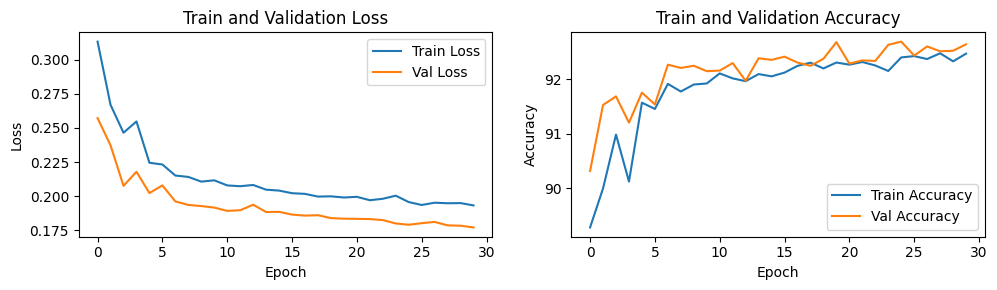

In [48]:
train_loss = hist['2_train_loss']
val_loss = hist['2_val_loss']

train_acc = hist['2_train_acc']
val_acc = hist['2_val_acc']

# set the figure size and create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# plot the train and val loss values in the first subplot
axs[0].plot(train_loss, label='Train Loss')
axs[0].plot(val_loss, label='Val Loss')
axs[0].set_title('Train and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the train and val accuracy values in the second subplot
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Val Accuracy')
axs[1].set_title('Train and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# adjust the layout of the subplots
plt.tight_layout()

# display the plot
plt.show()


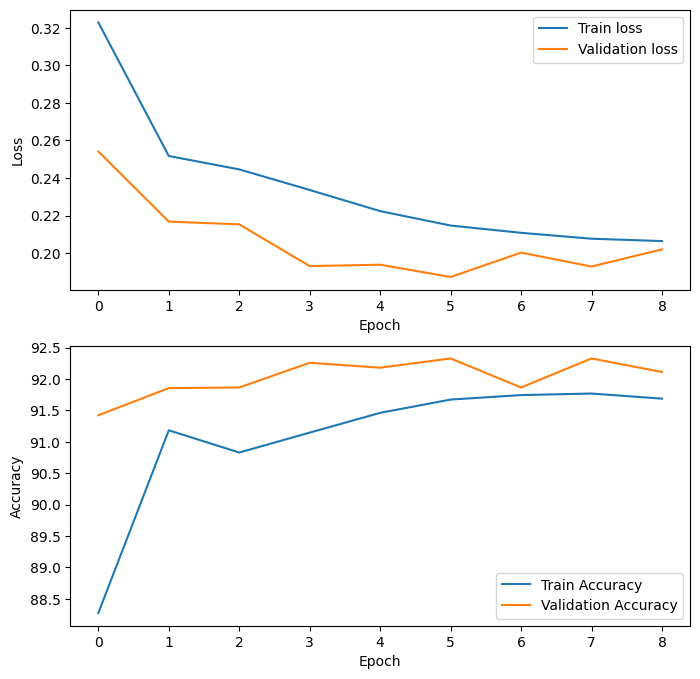

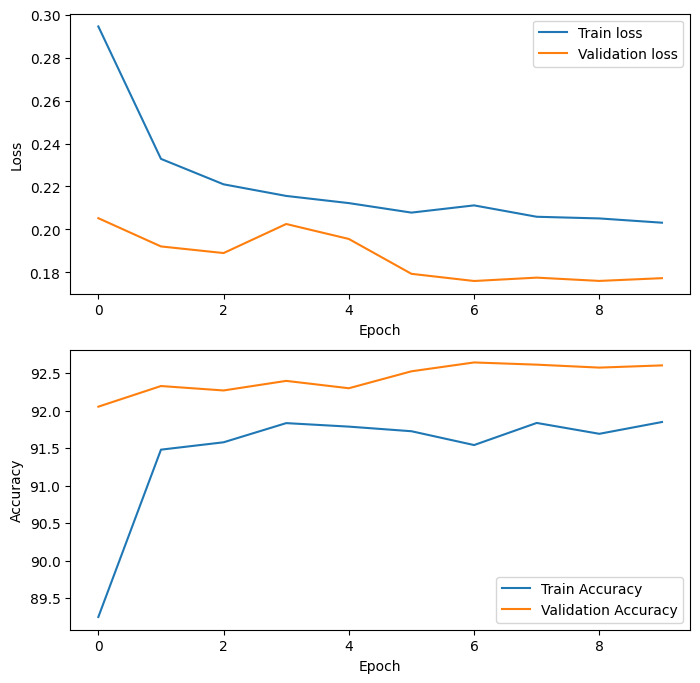

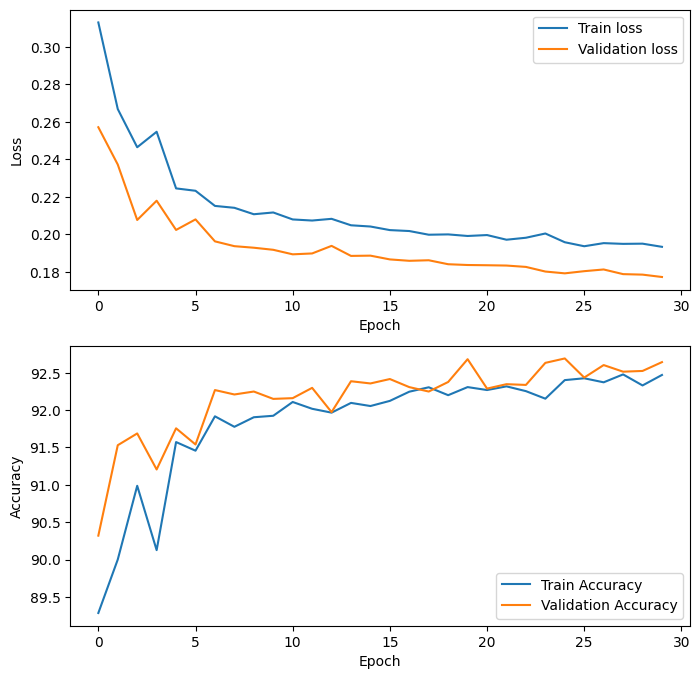

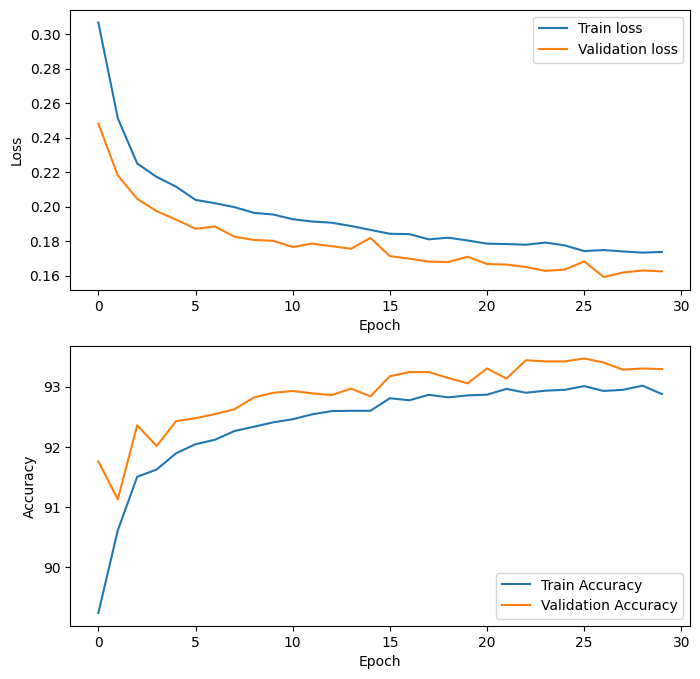

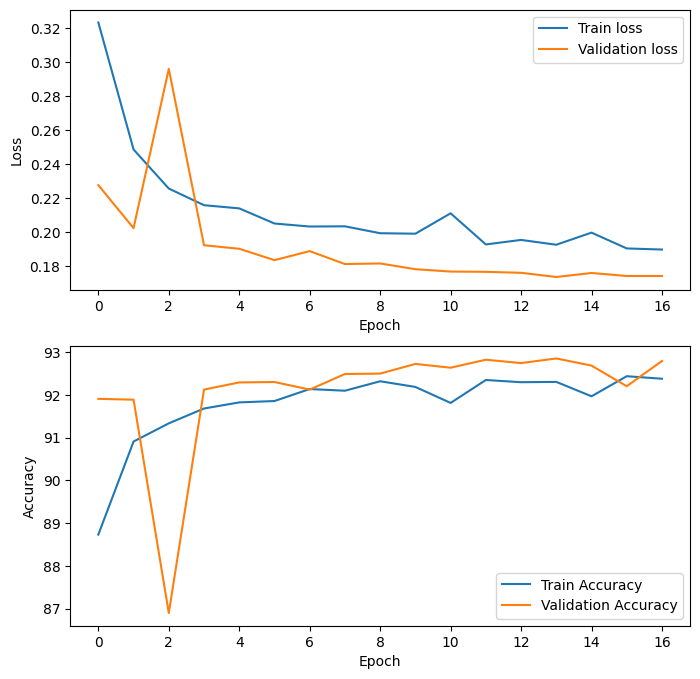

In [34]:
import matplotlib.pyplot as plt

# Loop through the different sets of histogram data
for i in range(5):
    # Get the train and validation loss and accuracy for this set
    train_loss = hist[f'{i}_train_loss']
    val_loss = hist[f'{i}_val_loss']
    train_acc = hist[f'{i}_train_acc']
    val_acc = hist[f'{i}_val_acc']

    # Create two subplots for the loss and accuracy plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Plot the train and validation loss on the first subplot
    ax1.plot(train_loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the train and validation accuracy on the second subplot
    ax2.plot(train_acc, label='Train Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Set the title of the plot based on the current set
    # fig.suptitle(f'Histogram Set {i}')

    # Show the plots
    plt.show()
